# quantitative experiment
MR reconstruction from original measurements

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

import h5py
from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import transforms

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Load MR images

In [3]:
def savefig(filename,img):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.savefig(filename,bbox_inches='tight')

In [4]:
def crop_center(img,cropx,cropy):
    #y,x = img.shape
    y = img.shape[-2]
    x = img.shape[-1]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    if len(img.shape) == 2:
        img_crop=img[starty:starty+cropy,startx:startx+cropx]
        return img_crop
    if len(img.shape) == 3:
        img_crop=img[0,starty:starty+cropy,startx:startx+cropx]
        return img_crop


In [5]:
def get_mri_imgs(mfiles=100,path = './fmri_datasets/singlecoil_val/'):
    data = []
    imgnames = [f for f in listdir(path) if isfile(join(path, f))]
    for i,imgname in enumerate(imgnames):
        filename = path + imgname#'./fastMRI-master/singlecoil_val/file1001077.h5'
        f = h5py.File(filename, 'r')
        
        #nu = int(f['kspace'].shape[0] / 2) # get a middle slice so there is content
        nu = int(f['kspace'].shape[0] / 2) # get a middle slice so there is content
        ksp = f['kspace'][nu]  # get full kspace measurement

        ksp = crop_center(ksp,320,640)
        #print(ksp.shape) #shape (640,320)
        
        # l2 reconstruction from full kspace measurement
        img_l2 = sp.ifft(ksp)
        #img_l2 = f['reconstruction_esc'][nu]

        rang = np.max(np.abs(img_l2)) #- np.min(np.abs(img_l2))
        img_l2 /= rang
        ksp /= rang
        data += [(ksp, np.real(img_l2))]
        if i>=mfiles-1:
            break
        #print(np.real(img_l2))
    print("collected ", len(data), " images")
    return data


collected  5  images


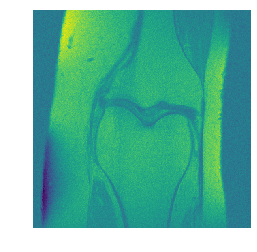

In [6]:
data = get_mri_imgs(5)
(ksp_np,img_ref) = data[0] #example, data 20, ksp: data full kspace measurement, img_ref: reconstruction from full kspace measurement
plt.imshow(crop_center(img_ref,320,320))#,cmap='gray')
plt.axis('off')
plt.show()

# Undersample and mask

mask shape: torch.Size([1, 1, 640, 320, 2])


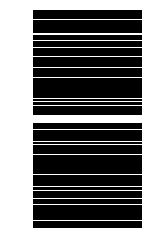

In [7]:
rng = np.random.RandomState()
center_fraction=0.04
num_cols=640
acceleration=8
num_low_freqs = int(round(num_cols * center_fraction))#center_fractions=[0.08, 0.04]
prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
mask2d = rng.uniform(size=num_cols) < prob
pad = (num_cols - num_low_freqs + 1) // 2
mask2d[pad:pad + num_low_freqs] = True
mask2d=mask2d[:,np.newaxis].repeat(320,axis=1)
mask2d=mask2d*1


wshape = img_ref.shape # (640,320)
mask = Variable( torch.zeros( (1,1,) + wshape + (2,) ) ).type(dtype)
mask[0,:,:,:,0] = np_to_var(mask2d)
mask[0,:,:,:,1] = np_to_var(mask2d)
print('mask shape:',mask.shape)
#maskcrop = crop_center(mask2d ,320,320)
savefig('mask.png',mask2d)

# Define Forward Model

In [8]:
def forwardm(img_var,mask=mask):
    fimg = Variable( torch.zeros(img_var.shape + (2,) ) ).type(dtype)
    fimg[:,:,:,:,0] = img_var #image data
    Fimg = transforms.fft2(fimg) #fourier transform to measurements
    return Fimg*mask #undersample measurements

# least squares reconstruction
def lsreconstruction(measurement):
    fimg = transforms.ifft2(measurement)
    return fimg[:,:,:,:,0]


#ksp: full kspace measurement to 2D fourier space representation
def ksp_np_to_measurement(ksp_np):
    Fimg = Variable( torch.zeros( (1,1,) + ksp_np.shape + (2,) ) ).type(dtype)
    Fimg[:,:,:,:,0] = np_to_var(np.real(ksp_np))
    Fimg[:,:,:,:,1] = np_to_var(np.imag(ksp_np))
    return Fimg

measurement = ksp_np_to_measurement(ksp_np)*mask
#measurement = ksp_np_to_measurement(ksp_np)
img_var = np_to_var( np.array([img_ref]) )
lsimg_var = lsreconstruction(measurement)

# Quantitative Experiment

In [9]:
def simulate_dd(func):
    psnrs = []
    ssims = []
    mses = []
    print("will average over ", len(data), "data")
    for i,(ksp_np,img_ref) in enumerate(data):
        img_var = np_to_var( np.array([img_ref]) ).type(dtype)
        out_img_var = func(measurement,img_var)
        out_img_np = out_img_var.data.cpu().numpy()[0]
        img_np = img_var.data.cpu().numpy()[0]
        psnrs += [psnr(img_np,out_img_np)]
        ssims += [ssim(img_np[0],out_img_np[0],dynamic_range=img_np.max()-img_np.min())]
        mses += [mse(img_np[0],out_img_np[0])]
        print(i,'psnr:',np.mean(psnrs))
        print(i,'ssim:',np.mean(ssims)) 
        print(i,'mse:',np.mean(mses)) 
    return psnrs,ssims,mses


# Deep decoder

In [18]:
torch.cuda.empty_cache()

In [19]:
def dd_recovery(measurement,img_var,k=128):
    #measurement = forwardm(img_var).type(dtype)

    num_channels = [k]*6
    net = decodernw(1,num_channels_up=num_channels,upsample_first = False,bias=True).type(dtype)
    #net = deconv_decoder(1,num_channels_up=num_channels,filter_size=2,stride=2,padding=0).type(dtype)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=0.0,num_iter=num_iter,LR = 0.0025,
                        img_noisy_var=measurement.type(dtype),
                        net=net,apply_f = forwardm,img_clean_var=img_var.type(dtype),
                        upsample_mode='bilinear',
                        )
    out_img_var = net( ni.type(dtype) )
    return out_img_var



In [20]:
num_iter=15000
k=128
psnrs128,ssims128,mses128 = simulate_dd(dd_recovery)

will average over  5 data
input shape:  [1, 128, 10, 5]
optimize with adam 0.0025
0 psnr: 29.56544563539424loss 0.008227  Actual loss 0.001110 Actual loss orig 0.001110 
0 ssim: 0.8395573807011831
0 mse: 0.0011052370613058571
input shape:  [1, 128, 10, 5]
optimize with adam 0.0025
1 psnr: 24.223535226853908oss 0.008231  Actual loss 0.012816 Actual loss orig 0.012816 
1 ssim: 0.6524747965446738
1 mse: 0.007021176592640861
input shape:  [1, 128, 10, 5]
optimize with adam 0.0025


KeyboardInterrupt: 

In [ ]:
print('PSNR:',np.mean(psnrs128))
print('SSIM:',np.mean(ssims128))
print('MSE:',np.mean(mses128))

In [77]:
torch.cuda.empty_cache()

In [78]:
k=256
psnrs256,ssims256,mses256 = simulate_dd(dd_recovery)

will average over  5 data
input shape:  [1, 128, 10, 5]
optimize with adam 0.005
1 psnr: 24.464469124692535oss 0.008244  Actual loss 0.012425 Actual loss orig 0.012425 
1 ssim: 0.6573398449878813
1 mse: 0.006554781238530684
input shape:  [1, 128, 10, 5]
optimize with adam 0.005
2 psnr: 22.698223543696994oss 0.008227  Actual loss 0.011569 Actual loss orig 0.011569 
2 ssim: 0.6611079196624118
2 mse: 0.00840914854486846
input shape:  [1, 128, 10, 5]
optimize with adam 0.005
3 psnr: 21.750168063308834oss 0.008227  Actual loss 0.012862 Actual loss orig 0.012862 
3 ssim: 0.6565428438081029
3 mse: 0.009523037595605856
input shape:  [1, 128, 10, 5]
optimize with adam 0.005


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [79]:
print('PSNR:',np.mean(psnrs256))
print('SSIM:',np.mean(ssims256))
print('MSE:',np.mean(ssims256))

PSNR: 20.759468149726494
SSIM: 0.6163299007897702
MSE: 0.6163299007897702


In [80]:
torch.cuda.empty_cache()
k=512
psnrs512,ssims512,mses512 = simulate_dd(dd_recovery)

will average over  5 data
input shape:  [1, 128, 10, 5]
optimize with adam 0.005
0 psnr: 29.69570024707686loss 0.008234  Actual loss 0.001069 Actual loss orig 0.001069 
0 ssim: 0.841622954082056
0 mse: 0.0010725806598143731
input shape:  [1, 128, 10, 5]
optimize with adam 0.005
1 psnr: 24.375576623809163oss 0.008241  Actual loss 0.012403 Actual loss orig 0.012403 
1 ssim: 0.654910026962739
1 mse: 0.006751055187373319
input shape:  [1, 128, 10, 5]
optimize with adam 0.005


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [81]:
print('PSNR:',np.mean(psnrs512))
print('SSIM:',np.mean(ssims512))
print('MSE:',np.mean(mses512))

PSNR: 20.778507531004845
SSIM: 0.6163962011416035
MSE: 0.0117282768613586


# L1 wavelet reconstruction

In [11]:
def get_l1wav(ksp_np,img_np,mask,from_ksp=False):
    mask2d=mask
    if from_ksp:
        y = ksp_np
    else:
        #mask2d = mr.poisson( img_np.shape , accel=accel, calib=calib).astype(float)
        y = sp.fft(img_np)*mask2d
    F = sp.linop.FFT(ksp_np.shape)
    P = sp.linop.Multiply(ksp_np.shape, mask2d)
    A = P * F

    lamda = 0.01 # best of 0.001, 0.01, 0.05, 0.005
    W = sp.linop.Wavelet(ksp_np.shape)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)

    img_l1wav = sp.app.LinearLeastSquares(A, y, proxg=proxg).run()
    return img_l1wav.astype(float)

#img_l1wav = get_l1wav(ksp_np,img_ref,mask2d)

# Toral Variation

In [12]:
def get_TV(ksp_np,img_np,mask):
    mask2d=mask
    #mask2d = mr.poisson( img_np.shape , accel=accel, calib=calib).astype(float)
    y = sp.fft(img_np)*mask2d
    F = sp.linop.FFT(ksp_np.shape)
    P = sp.linop.Multiply(ksp_np.shape, mask2d)
    A = P * F

    lamda = 0.02 # best of: 0.001, 0.005, 0.01, 0.02, 0.05
    #W = sp.linop.Wavelet(ksp_np.shape)
    #proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)
    G = sp.linop.Gradient(img_np.shape)
    proxg = sp.prox.L1Reg(G.oshape, lamda)
    
    img_TV = sp.app.LinearLeastSquares(A, y, proxg=proxg,G=G).run()
    return img_TV.astype(float)

#img_TV = get_TV(img_ref,mask2d)


In [13]:
def simulate_np(func):
    psnrs = []
    ssims = []
    mses = []
    for i,(ksp_np,img_ref) in enumerate(data):
        out_img_np = func(ksp_np,img_ref,mask2d)
        psnrs += [psnr(img_ref,out_img_np)]
        ssims += [ssim(img_ref,out_img_np,dynamic_range=img_ref.max()-img_ref.min())]
        mses += [mse(img_ref,out_img_np)]
        print(i,'psnr:',np.mean(psnrs))
        print(i,'ssim:',np.mean(ssims)) 
        print(i,'mse:',np.mean(mses))
    return psnrs,ssims,mses

In [14]:
psnrsl1,ssimsl1,msesl1 = simulate_np(get_l1wav)


0 psnr: 31.25507250930546
0 ssim: 0.8536912933281667
0 mse: 0.0007490188528740402



1 psnr: 28.76237827499756
1 ssim: 0.7591472147257274
1 mse: 0.0015548344112844776



2 psnr: 31.099631490468813
2 ssim: 0.8210260368100615
2 mse: 0.001124755536578601



3 psnr: 31.48048270981379
3 ssim: 0.8374200225140909
3 mse: 0.0009802250650840603



4 psnr: 30.336336365548526
4 ssim: 0.8060805269339824
4 mse: 0.001315131606769348


In [15]:
psnrstv,ssimstv,msestv = simulate_np(get_TV)
print(np.mean(psnrstv))


0 psnr: 31.42464860163387
0 ssim: 0.8549083808631381
0 mse: 0.0007203360330437553



1 psnr: 28.793838837809325
1 ssim: 0.748061345023048
1 mse: 0.0015698385366200865



2 psnr: 31.254374907814622
2 ssim: 0.8151250612096489
2 mse: 0.0011269734641541284



3 psnr: 31.648842574881975
3 ssim: 0.8331324425611897
3 mse: 0.0009754614206813718



4 psnr: 30.531752051748526
4 ssim: 0.8007478368108666
4 mse: 0.0012754669402195006
30.531752051748526


In [82]:
print('PSNR:')
print('k=128:',np.mean(psnrs128))
print('k=256:',np.mean(psnrs256))
print('k=512:',np.mean(psnrs512))
print('L1:',np.mean(psnrsl1))
print('TV:',np.mean(psnrstv))

print('SSIM:')
print('k=128:',np.mean(ssims128))
print('k=256:',np.mean(ssims256))
print('k=512:',np.mean(ssims512))
print('L1:',np.mean(ssimsl1))
print('TV:',np.mean(ssimstv))

print('MSE:')
print('k=128:',np.mean(mses128))
print('k=256:',np.mean(mses256))
print('k=512:',np.mean(mses512))
print('L1:',np.mean(msesl1))
print('TV:',np.mean(msestv))

PSNR:
k=128: 20.8275769339526
k=256: 20.759468149726494
k=512: 20.778507531004845
L1: 30.427712625667425
TV: 30.55026432118808
SSIM:
k=128: 0.6169204896082732
k=256: 0.6163299007897702
k=512: 0.6163962011416035
L1: 0.8063642205182722
TV: 0.8005383303480264
MSE:
k=128: 0.011643834299344716
k=256: 0.011800228520230837
k=512: 0.0117282768613586
L1: 0.0012980122712425571
TV: 0.0012735424406878678
